In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')
print(blosum92)
print(len(AA_list))

[[ 4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1  0 -4]
 [-1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1  0 -1 -4]
 [-2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  3  0 -1 -4]
 [-2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4  1 -1 -4]
 [ 0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -3 -2 -4]
 [-1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0  3 -1 -4]
 [-1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4]
 [ 0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -2 -1 -4]
 [-2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0  0 -1 -4]
 [-1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3 -3 -1 -4]
 [-1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4 -3 -1 -4]
 [-1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0  1 -1 -4]
 [-1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3 -1 -1 -4]
 [-2 -3 -3 -3 -2 -3 -3 -3

In [3]:
avg92 = jnp.sum(blosum92)/24/24
sum92 = 0.
for row in blosum92:
    for aa in row:
        sum92 += (aa-avg92)**2
std92 = jnp.sqrt(sum92 / 24/24)
print(avg92)
print(std92)

-1.2604167
2.166242


In [4]:
def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += (blosum92[idx1][idx2] - avg92)/std92
        #jax.nn.sigmoid(score/len(seqlist1))
    return score/len(seqlist1)
    #return score/len(seqlist1)

In [5]:
blosum(target_seq, 'TAEGETPEETIDE')

NameError: name 'target_seq' is not defined

In [6]:
#target_seq = 'GIGAVLKVLTTGLPALISWIKRKRQQSSVAAWRPPKL'
#target_seq = 'HAPPYGIRLS'
target_seq = 'TARGETPEPTIDE'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
#print(target_rep.shape)

'''
seqs = [
    'AHKSQYFPDAYVFSEHDVGTYWGKFQCANFTNERLDC',
    'KPHFEDCDYMLPMQQIGLYCEKYCAFHSYWPWCFVSK',
    'AHWEWRMPWMSPLADDEYWDNGNDNPVKSGKLHPCDE',
    'ITACDQYLWGWMVTGFFDSGDMTDAMIANKHKWLFYV',
    'GDIGHQWGGFSWWHMWMCAVCQPVTKSMRRLTRSSTQ',
    'DFECGPQRTHVEPDKASSFFNPCLAVSMSTLFYAVNE',
    'GCHEYAATIEGHTDDCKPELDMWCHGLIGRYMQRYQP',
    'VHISALDSYVSGSNPRPQDYMMGPTRWCCYGCWVHYE',
    'ILMVIADVNMYVVQWEYYQMWRALHEFWAVPGKMCQM',
    'CNCWMKCCMPFLHEPSADLCSWPYWYNNWQLRQACRT'
]

'''
seqs = ['ISQLRYICEVIWF']

'''
seqs = ['CNCWMKCCMP',
        'RPWTQRPDTM',
        'FLNRCKYTGI',
        'EGHIMMFMRM',
        'RSVWNNDEFV',
        'THQHTWALQA',
        'CNANVDGAEQ',
        'KLAMDCPNTF']
'''



reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)

print(labels)

            
#val_reps = get_reps(seqs)[0]
#val_labels = []
#for val_seq in val_seqs:
#    val_labels.append(blosum(target_seq, val_seq))
#val_labels = np.array(val_labels)
#print(val_labels)

[0.01368617]


In [25]:
pca = PCA(n_components=2)
pca.fit(reps)
proj_x = pca.transform(reps)
plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
plt.colorbar()
proj_l = pca.transform(target_rep)
plt.plot(proj_l[:,0], proj_l[:,1], 'p')

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [7]:
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
forward_fxn, full_forward_fxn = alpdesign.build_model(c)
full_forward_t = hk.without_apply_rng(hk.transform(full_forward_fxn))

In [8]:
#params, losses = alpdesign.ensemble_train(
#    key, full_forward_t, c, reps, labels, epochs=50, learning_rate=2e-4)
forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
#forward = functools.partial(forward_t.apply, params)
#plt.plot(losses)

In [9]:
# e2e is a haiku func
def e2e(params, logits): # params is trained mlp params
    s = alpdesign.SeqpropBlock()(logits)
    us = alpdesign.seq2useq(s)
    u = alpdesign.differentiable_jax_unirep(us)
    forward = functools.partial(forward_t.apply, params)
    return forward(u)
#e2e_t = hk.transform(e2e)
#init_logits = jax.random.normal(key, shape=((10, 20)))
#e2e_params = e2e_t.init(key, init_logits)

def e2e_fxn(e2e_t, x, key):
    e2e_params, logits = x
    yhat = e2e_t.apply(e2e_params, key, logits)
    return yhat

In [10]:
batch_size = 8
BO_batch_size = 32
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
def loop(key, reps, labels, params, rb=None):
    key, train_key = jax.random.split(key, num=2)
    params, mlp_loss= alpdesign.ensemble_train(train_key, full_forward_t, c, reps, 
                                                         labels, 
                                                         params=params, batch_size=batch_size, epochs=160, learning_rate=2e-4)
    # make random point
    init_logits = jax.random.normal(key, shape=((13, 20)))
    e2e_ = lambda logits: functools.partial(e2e, params)(logits)
    e2e_t = hk.transform(e2e_)
    key, train_key = jax.random.split(key, num=2)
    if rb is None:
        rb = e2e_t.init(key, init_logits)
    e2e_params = rb
    key, train_key = jax.random.split(key, num=2)
    init_x = 0.1*jax.random.normal(key, shape=(BO_batch_size, 13, 20))
    #forward = jax.vmap(lambda x, key: forward_t.apply(params, x), in_axes=(0, None))
    print('start BO')
    #batch_e2e = jax.vmap(lambda x, key: functools.partial(e2e_fxn, e2e_t)(params, x), in_axes=((None, 0), None))
    batch_e2e = jax.vmap(functools.partial(e2e_fxn, e2e_t), ((None, 0), None), (0, 0))
    #batched_x, bo_losses = alpdesign.mlp.bayes_opt(key, batch_e2e, labels, (e2e_t.init(train_key, init_logits), init_x), epsilon=0.01, iter_num=500)
    batched_x, bo_losses = alpdesign.mlp.bayes_opt(key, batch_e2e, labels, (e2e_params, init_x), epsilon=0.01, iter_num=500, learning_rate=1e-2)
    top_idx = np.argmin(bo_losses[-1])
    rb = batched_x[0]
    batched_logits = batched_x[1]
    final_logits = batched_logits[top_idx]
    bo_losses = jnp.array(bo_losses)
    bo_loss = bo_losses[...,top_idx]
    vec = alpdesign.seq.forward_seqprop.apply(rb, key, final_logits)
    s = decode_seq(vec)
    reps = np.concatenate((reps, get_reps([s])[0]))
    #print(get_reps([s])[0])
    y = blosum(target_seq, s)
    predicted_y = forward_t.apply(params, get_reps([s])[0])[0]
    #print(reps.shape)
    print(s, y, predicted_y)
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    '''
    plt.figure()
    proj_x = pca.transform(reps)
    #print(proj_x)
    plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
    plt.colorbar()
    proj_l = pca.transform(target_rep)
    plt.plot(proj_l[:,0], proj_l[:,1], 'p')
    plt.plot(proj_x[-1, 0], proj_x[-1, 1], 'o', color='green')    
    plt.show()
    
    '''
    return key, reps, labels, s, params, rb, bo_loss, mlp_loss

    

In [11]:
#key = jax.random.PRNGKey(0)
y = []
yhat = []
for i in range(100):
    print(i)
    rb = None
    params = None
    key, _ = jax.random.split(key, num=2)
    key, reps, labels, final_vec, params, rb, bo_loss, mlp_loss= loop(key, reps, labels, params, rb)
    y.append(blosum(target_seq, final_vec))
    yhat.append(forward_t.apply(params, get_reps([final_vec])[0])[0])
    #plt.figure()
    #plt.plot(bo_loss)
    #plt.show()
    #print(final_vec)

0
start BO
['C', 'D', 'S', 'C', 'G', 'Q', 'C', 'W', 'K', 'K', 'S', 'C', 'Q'] -0.16386345 0.029684309
1
start BO
['M', 'L', 'L', 'M', 'I', 'M', 'F', 'I', 'A', 'V', 'F', 'I', 'M'] -0.27039322 0.036183245
2
start BO
['V', 'K', 'W', 'Y', 'K', 'E', 'E', 'Y', 'E', 'I', 'D', 'H', 'H'] 0.013686148 0.03654059
3
start BO
['S', 'Q', 'I', 'K', 'E', 'L', 'K', 'K', 'H', 'V', 'R', 'K', 'Y'] 0.2622556 0.0219163
4
start BO
['K', 'L', 'K', 'E', 'L', 'E', 'E', 'Q', 'V', 'K', 'K', 'I', 'E'] 0.2622556 0.35077077
5
start BO
['K', 'L', 'R', 'E', 'Q', 'L', 'E', 'E', 'L', 'E', 'R', 'E', 'R'] 0.61735487 0.23364091
6
start BO
['R', 'M', 'Q', 'E', 'Q', 'I', 'T', 'E', 'R', 'E', 'R', 'R', 'Q'] 0.43980518 0.38357434
7
start BO
['R', 'E', 'Q', 'R', 'R', 'R', 'E', 'E', 'E', 'R', 'R', 'R', 'R'] 0.33327544 0.7106557
8
start BO
['E', 'L', 'R', 'E', 'R', 'L', 'A', 'E', 'Q', 'L', 'A', 'A', 'E'] 0.7238845 0.46268803
9
start BO
['E', 'Q', 'L', 'R', 'A', 'A', 'L', 'E', 'A', 'Q', 'L', 'A', 'A'] 0.29776552 0.73369807
10
start B

83
start BO
['W', 'V', 'R', 'E', 'E', 'I', 'E', 'Q', 'E', 'V', 'E', 'E', 'E'] 0.9014342 0.86253303
84
start BO
['R', 'I', 'R', 'E', 'R', 'V', 'A', 'E', 'A', 'V', 'E', 'E', 'E'] 0.8659243 0.8413537
85
start BO
['W', 'I', 'R', 'D', 'E', 'V', 'E', 'E', 'E', 'V', 'A', 'E', 'E'] 1.1144938 0.8679504
86
start BO
['W', 'I', 'K', 'E', 'E', 'V', 'A', 'A', 'E', 'V', 'E', 'E', 'E'] 0.68837464 0.873558
87
start BO
['W', 'I', 'R', 'E', 'E', 'V', 'E', 'A', 'D', 'V', 'A', 'E', 'D'] 0.7593945 0.8773392
88
start BO
['W', 'V', 'E', 'E', 'I', 'R', 'E', 'E', 'I', 'E', 'E', 'E', 'D'] 0.33327544 0.808478
89
start BO
['W', 'I', 'R', 'E', 'E', 'V', 'A', 'E', 'E', 'I', 'E', 'Q', 'E'] 0.90143424 0.82852536
90
start BO
['R', 'I', 'R', 'E', 'R', 'V', 'E', 'A', 'E', 'V', 'A', 'E', 'E'] 0.7238845 0.84800833
91
start BO
['W', 'V', 'R', 'E', 'R', 'A', 'A', 'E', 'E', 'A', 'E', 'D', 'E'] 1.0079639 0.77666205
92
start BO
['W', 'V', 'K', 'E', 'E', 'V', 'R', 'D', 'E', 'A', 'A', 'E', 'E'] 0.8659243 0.77908915
93
start BO
['

Text(0.5, 1.0, 'Blosum Score vs N')

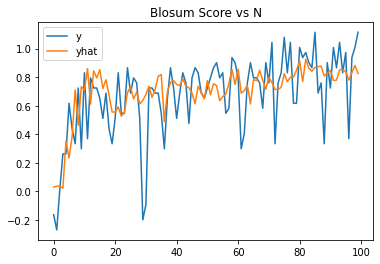

In [15]:
plt.figure()
plt.plot(y,label='y')
plt.plot(yhat, label='yhat')
plt.legend()
plt.title('Blosum Score vs N')

In [44]:
ys_01 = ys

In [16]:
import pickle

with open('y.pkl', 'wb') as f1:
    pickle.dump(y, f1)
    
with open('yhat.pkl', 'wb') as f2:
    pickle.dump(yhat, f2)

In [ ]:
'S', 'G', 'K', 'Y', 'Y', 'F', 'F', 'H', 'H', 'F'
'H', 'V', 'Y', 'V', 'F', 'G', 'G', 'Y', 'E', 'Y'
['GIGAVLKILIAAARPREAITAALKKR']
['GIGAVLKVLTTGLPALISWIKRKRQQ']
['H', 'K', 'D', 'I', 'I', 'K', 'A', 'E', 'G', 'V', 'K', 'E', 'G', 'E', 'P', 'I', 'G', 'P', 'C', 'I', 'N', 'N', 'S', 'Q', 'C', 'P'] 0.3318122
['A', 'G', 'D', 'P', 'I', 'K', 'C', 'V', 'R', 'V', 'G', 'E', 'T', 'I', 'P', 'E', 'G', 'S', 'P', 'L', 'M', 'P', 'C', 'M', 'M', 'T'] 0.3318122